# Make Moons - Linear vs Deep Neural Networks
In this notebook, I explore how different neural network architectures perform on a small two-dimensional dataset  
The goal is to compare a simple linear model with deeper neural networks and observe how model complexity affects performance

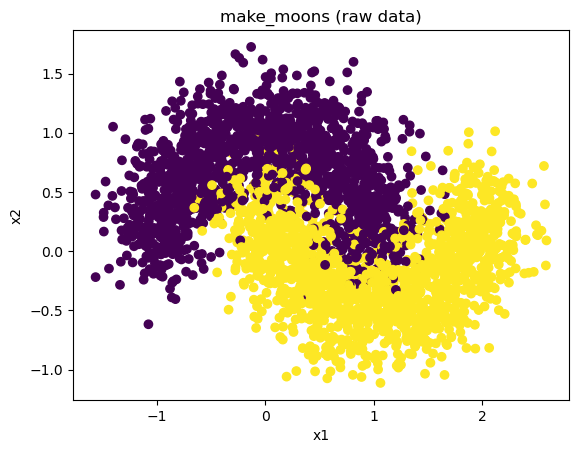

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.datasets import make_moons

tf.keras.utils.set_random_seed(0)

X, y = make_moons(n_samples = 3000, noise = 0.25, random_state = 0)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.title("make_moons (raw data)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Data Splitting
The data is split into training, validation, and test sets:
- The training set is used to fit the models
- The validation set is used to compare models
- The test set is used only at the end for final evaluation

In [4]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2, random_state = 0, stratify = y_trainval)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape, sep = "\n")

Train:
(1920, 2)
Val:
(480, 2)
Test:
(600, 2)


## Feature Scaling
I standardize the features using statistics from the training set only  
This helps stabilize training and avoids data leakage

In [6]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

n_features = X_train_s.shape[1]
n_features

2

## Helper Functions
I define a few small helper functions:
- `plot_loss()` plots training and validation loss curves
- `get_accuracy()` computes classification accuracy on a given dataset
- `show_probability_map()` visualizes model predictions across the feature space

In [8]:
def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history["loss"], label = "train_loss")
    plt.plot(history.history["val_loss"], label = "val_loss")
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

def get_accuracy(model, X_eval, y_eval, name):
    prob = model.predict(X_eval, verbose = 0).ravel()
    pred = (prob >= 0.5).astype(int)
    acc = accuracy_score(y_eval, pred)
    print(f"{name} accuracy: {acc:.4f}")
    return acc

def show_probability_map(model, X_points_scaled, y_points, title, N = 20000):
    x_min, x_max = X_points_scaled[:, 0].min() - 0.5, X_points_scaled[:, 0].max() + 0.5
    y_min, y_max = X_points_scaled[:, 1].min() - 0.5, X_points_scaled[:, 1].max() + 0.5

    xs = np.random.uniform(x_min, x_max, N)
    ys = np.random.uniform(y_min, y_max, N)
    bg_points = np.column_stack([xs, ys])

    bg_prob = model.predict(bg_points, verbose = 0).ravel()

    plt.figure()
    plt.scatter(bg_points[:, 0], bg_points[:, 1], c = bg_prob, s = 5, alpha = 0.25)
    plt.scatter(X_points_scaled[:, 0], X_points_scaled[:, 1], c = y_points, edgecolors = "k", s = 25)
    plt.title(title)
    plt.xlabel("x1 (scaled)")
    plt.ylabel("x2 (scaled)")
    plt.show()

## Model 1: Linear Baseline
I start with the simplest possible neural network: a single neuron with sigmoid activation  
This model can only learn a straight decision boundary  
Next, I increase model complexity to see if performance improves

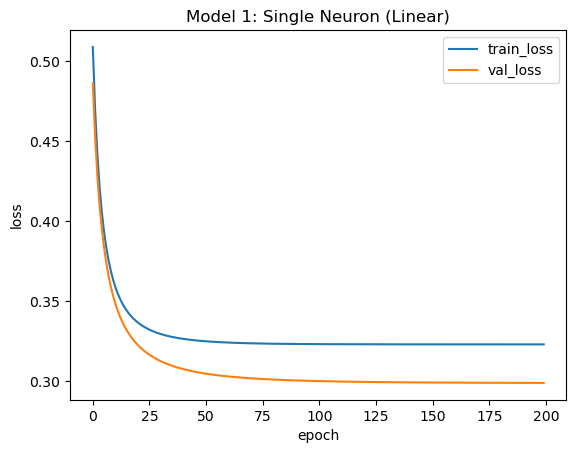

Model 1 (val) accuracy: 0.8729


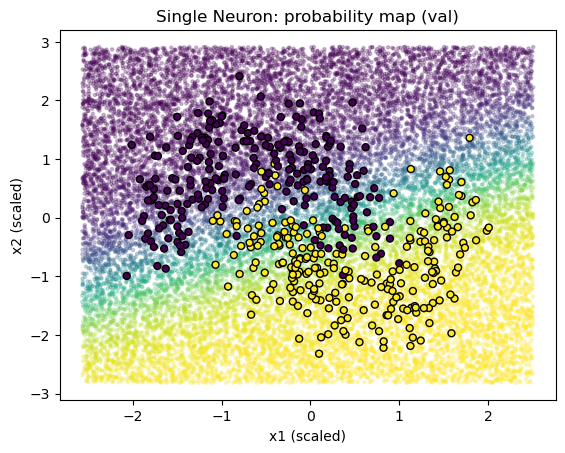

In [10]:
model1 = Sequential([
    Input(shape = (n_features,)),
    Dense(1, activation = "sigmoid")])

model1.compile(
    optimizer = "sgd",
    loss = "binary_crossentropy",
    metrics = ["accuracy"])

history1 = model1.fit(
    X_train_s, y_train,
    validation_data = (X_val_s, y_val),
    epochs = 200,
    batch_size = 32,
    verbose = 0)

plot_loss(history1, "Model 1: Single Neuron (Linear)")
val_acc1 = get_accuracy(model1, X_val_s, y_val, "Model 1 (val)")
show_probability_map(model1, X_val_s, y_val, "Single Neuron: probability map (val)")

## Model 2: Deep Neural Network
This model includes hidden layers with ReLU activation  
Hidden layers allow the model to learn non-linear relationships between the two input features  
The deeper model achieves better validation performance  
This suggests that the data may require a non-linear decision boundary

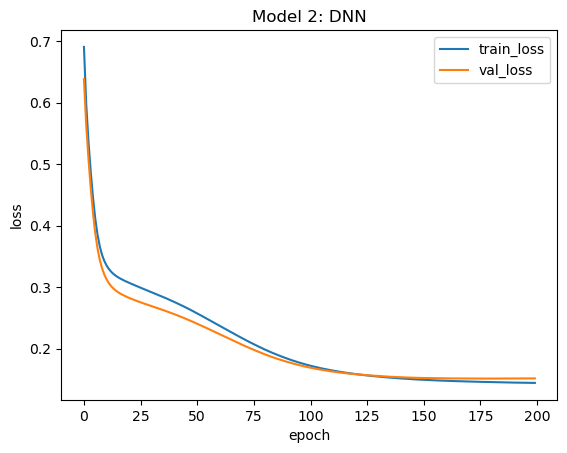

Model 2 (val) accuracy: 0.9250


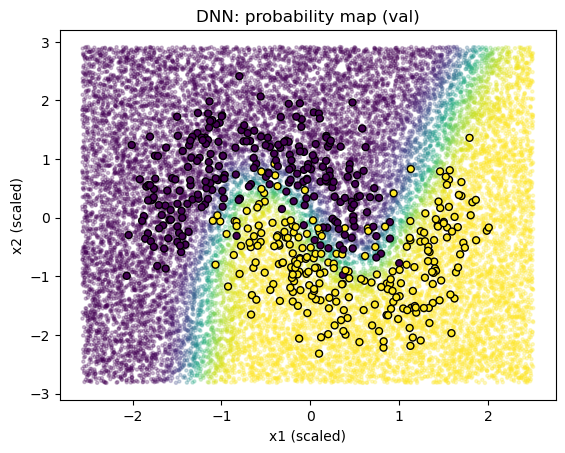

In [12]:
model2 = Sequential([
    Input(shape = (n_features,)),
    Dense(32, activation = "relu"),
    Dense(16, activation = "relu"),
    Dense(1, activation = "sigmoid")])

model2.compile(
    optimizer = "sgd",
    loss = "binary_crossentropy",
    metrics = ["accuracy"])

history2 = model2.fit(
    X_train_s, y_train,
    validation_data = (X_val_s, y_val),
    epochs = 200,
    batch_size = 32,
    verbose = 0)

plot_loss(history2, "Model 2: DNN")
val_acc2 = get_accuracy(model2, X_val_s, y_val, "Model 2 (val)")
show_probability_map(model2, X_val_s, y_val, "DNN: probability map (val)")

## Regularization
To reduce overfitting, I apply Dropout and EarlyStopping  
These techniques help the model generalize better and prevent unnecessary training

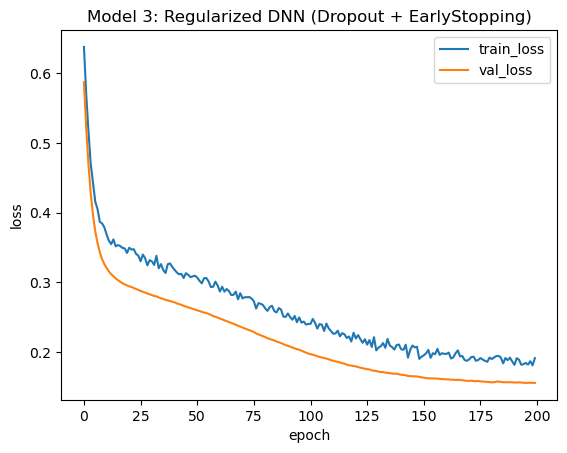

Model 3 (val) accuracy: 0.9313


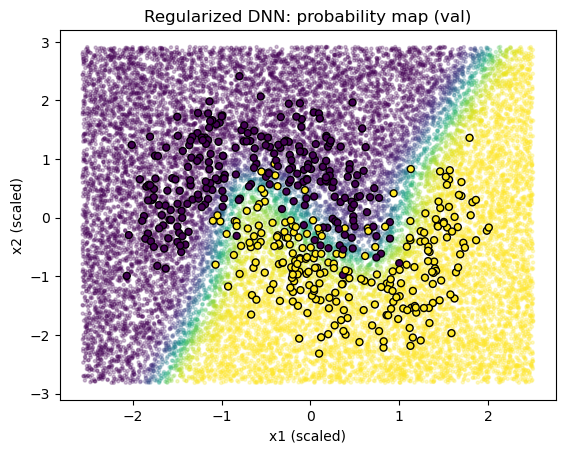

In [14]:
early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 15,
    restore_best_weights = True)

model3 = Sequential([
    Input(shape = (n_features,)),
    Dense(64, activation = "relu"),
    Dropout(0.3),
    Dense(32, activation = "relu"),
    Dropout(0.3),
    Dense(1, activation = "sigmoid")])

model3.compile(
    optimizer = "sgd",
    loss = "binary_crossentropy",
    metrics = ["accuracy"])

history3 = model3.fit(
    X_train_s, y_train,
    validation_data = (X_val_s, y_val),
    epochs = 200,
    batch_size = 32,
    callbacks = [early_stop],
    verbose = 0)

plot_loss(history3, "Model 3: Regularized DNN (Dropout + EarlyStopping)")
val_acc3 = get_accuracy(model3, X_val_s, y_val, "Model 3 (val)")
show_probability_map(model3, X_val_s, y_val, "Regularized DNN: probability map (val)")

## Model Comparison
I compare validation accuracy across all models to evaluate how model complexity affects performance  

In [16]:
print("Validation accuracy comparison:")
print(f"Single neuron: {val_acc1:.4f}")
print(f"DNN         : {val_acc2:.4f}")
print(f"Regularized : {val_acc3:.4f}")

Validation accuracy comparison:
Single neuron: 0.8729
DNN         : 0.9250
Regularized : 0.9313


## Final Test Evaluation
The best-performing model on validation data is evaluated on the test set to estimate generalization performance

In [18]:
val_accs = np.array([val_acc1, val_acc2, val_acc3])
best_idx = int(np.argmax(val_accs))
best_model = [model1, model2, model3][best_idx]
best_name = ["single_neuron", "dnn", "regularized_dnn"][best_idx]

test_acc = get_accuracy(best_model, X_test_s, y_test, f"Best model ({best_name}) test")

Best model (regularized_dnn) test accuracy: 0.9467
